# Gotham City Cabs
Anutida Sangkla 

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
import warnings 
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import seaborn as sns
from scipy import stats
from scipy.stats import skew,norm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

### Loading csv files 

In [2]:
train = pd.read_csv("gs://msa8150/Train.csv",low_memory = False)
test =  pd.read_csv("gs://msa8150/Gotham_Test_Set.csv",low_memory = False)
train_df = train.copy()

In [3]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

### Data exploration

In [4]:
train.head()

,pickup_datetime,NumberOfPassengers,duration,pickup_x,pickup_y,dropoff_x,dropoff_y
0,2034-01-30 10:24:44,1,724,162.837930,341.187316,160.391473,367.907042
1,2034-03-09 23:10:11,1,127,150.375222,307.042187,152.623686,318.383231
2,2034-05-02 20:23:17,6,386,156.586093,333.063670,169.397955,315.001104
3,2034-06-21 17:51:55,1,1192,161.738726,344.609009,167.702052,310.817653
4,2034-05-15 18:38:15,2,315,174.419521,344.441542,165.780203,344.275954


In [5]:
test.head()

,pickup_datetime,NumberOfPassengers,pickup_x,pickup_y,dropoff_x,dropoff_y
0,2034-03-07 08:18:38,1,161.621556,378.392680,154.576631,357.100229
1,2034-05-25 22:17:59,6,155.861811,378.814369,152.096261,371.937385
2,2034-02-20 11:44:58,1,149.134396,358.166672,154.228104,350.994666
3,2034-04-20 20:37:17,1,151.383779,311.295334,143.709998,322.694772
4,2034-06-14 11:30:47,1,148.365303,336.804890,144.565196,303.796307


#### Analyzing target variable

We can observe that this dataset includes 6 features which we can use to predict duration time.

In [6]:
train['duration'].describe()

count    1000000.000000
mean         696.646542
std          544.929446
min            0.000000
25%          330.000000
50%          551.000000
75%          894.000000
max         5944.000000
Name: duration, dtype: float64

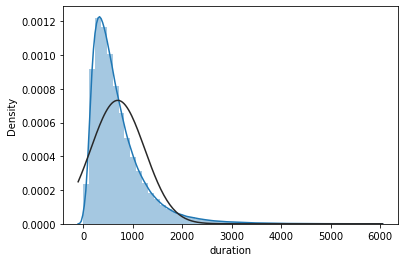

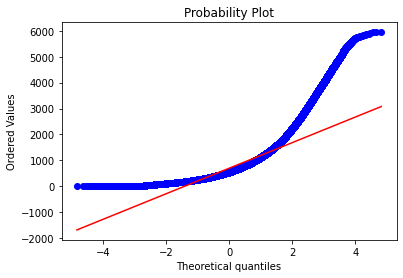

In [7]:
# test normality
sns.distplot(train.duration,fit = norm);(mu, sigma) = norm.fit(train['duration'])

# Q-Q plot
fig = plt.figure()
res = stats.probplot(train['duration'], plot = plt)
plt.show()

From the plots, the duration of the trip seems not to be normally distributed.

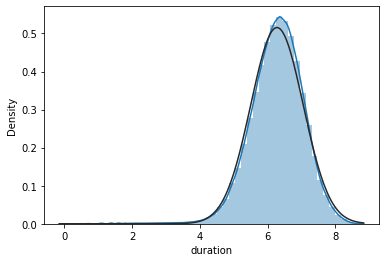

In [8]:
sns.distplot(np.log1p(train['duration']), fit=norm);

After we took log to the respond variable, the duration of the trip seems normally distributed. Therefore, we will take log to our respond variable.

In [9]:
#train['duration'] = np.log(train['duration'])
#train.head()

#### Exploring Pickup and Dropoff features 

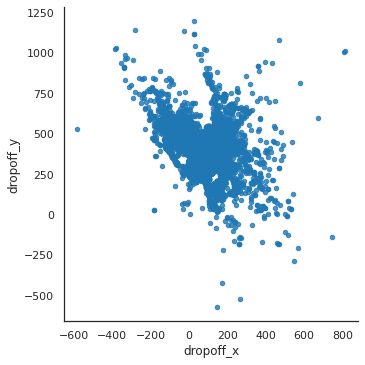

In [10]:
sns.set_context("notebook", font_scale=1)
sns.set_style("white")
# Create scatterplot of dataframe
sns.lmplot('dropoff_x', 'dropoff_y', data=train, fit_reg=False, scatter_kws={"marker": "o", "s": 20})

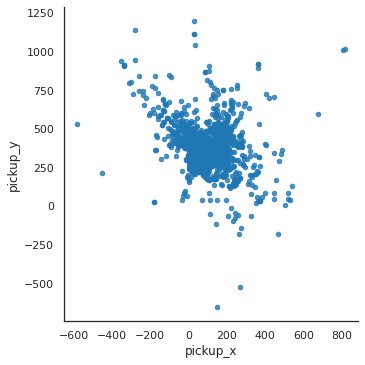

In [11]:
sns.set_context("notebook", font_scale=1)
sns.set_style("white")
# Create scatterplot of dataframe
sns.lmplot('pickup_x', 'pickup_y', data=train, fit_reg=False, scatter_kws={"marker": "o", "s": 20})

We may create new features by using kmeans to cluster pickup and drop off features. Also, finding the distance between pickup and dropoff might increase the predicted accuracy of trip duration since the distance is an important feature that contributes to trip duration. As a result, we will create distance related features by calculating distance in different methods,  such as manhattan distance and euclidean distance.

## Building models

#### Principal Component Analysis

In [12]:
from sklearn.decomposition import PCA
X = train.loc[:, ~train.columns.isin(['duration', 'pickup_datetime'])]
y = train['duration']
pca = PCA(2)  # project from 5 to 2 dimensions
projected = pca.fit_transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", projected.shape)

original shape:    (1000000, 5)
transformed shape: (1000000, 2)


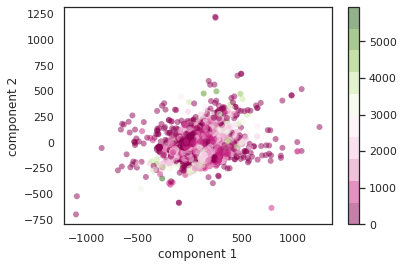

In [13]:
plt.scatter(projected[:, 0], projected[:, 1],
            c= y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('PiYG', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 5-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance. Essentially, we have found the optimal stretch and rotation in 5-dimensional space that allows us to see the layout of the durations in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

#### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

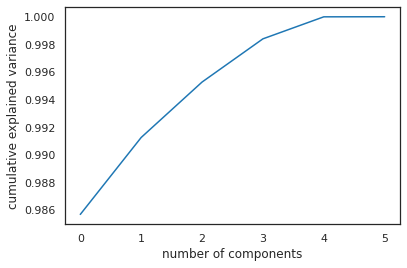

In [14]:
train_new = train_df.loc[:, ~train.columns.isin(['pickup_datetime'])]
pca = PCA().fit(train_new)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 5-dimensional variance is contained within the first N components. For example, we see that with the train data, we need around 5 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses information (as measured by the explained variance) and that we'd need about 5 components to retain ~100% of the variance. Looking at this plot for a high-dimensional dataset can help we understand the level of redundancy present in multiple observations.

##### Starting with the basic model like linear regression with orginal features, 5 components, to understand the relationship between features and the respond variable and exclude pickup datetime: 

In [15]:
lm = LinearRegression()
cv = KFold(n_splits=5, random_state=1, shuffle=True) 
scores = cross_val_score(lm, X, y, cv=cv)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.20 accuracy with a standard deviation of 0.00


From the result, it seems not to be good to exclude pickup datetime; as a result, we will split date and time into minute, hour, month, dayofweek, weekday, and weekend features to predict trip duration.

### Creating new features

In [16]:
def features(df):
    df['minute'] = df['pickup_datetime'].dt.hour*60 + df['pickup_datetime'].dt.minute
    df['weekday'] = df['pickup_datetime'].dt.weekday
    df['weekend'] = df['weekday'].map(lambda x: 1 if x >= 5 else 0)
    df['hour'] = df['pickup_datetime'].dt.hour
    df['month'] = df['pickup_datetime'].dt.month
    remove = ['pickup_datetime']
    df = df[[x for x in df.columns if x not in remove]]
    kmeans = KMeans(n_clusters=10, random_state=42)
    df['cluster_pickup'] = kmeans.fit_predict(df[['pickup_x','pickup_y']])
    df['cluster_dropoff'] = kmeans.fit_predict(df[['dropoff_x','dropoff_y']])
    df['euclidean_dist'] = df.apply(lambda x: np.linalg.norm(np.array((x.pickup_x,x.pickup_y))-np.array((x.dropoff_x,x.dropoff_y))) ,axis=1)
    df['manhattan_dist'] = df.apply(lambda x: abs(x.dropoff_x-x.pickup_x)+abs(x.dropoff_y-x.pickup_y) ,axis=1)
    df['dir_x'] = df.apply(lambda x: (x.dropoff_x-x.pickup_x)/x.euclidean_dist,axis=1)
    df['dir_y'] = df.apply(lambda x: (x.dropoff_y-x.pickup_y)/x.euclidean_dist,axis=1)
    return df

In [ ]:
feat_tr = features(train)
feat_ts = features(test)

### Data pre-processing: Standardized data and encoded data

In [ ]:
def scale(df,scaled_feat):
    scaler = preprocessing.StandardScaler()
    for feat in scaled_feat:
        df[feat] = scaler.fit_transform(df[[feat]])
        return df
def encode(df,encoded_feat):
    le = LabelEncoder()
    for feat in encoded_feat:
        le.fit(df[[feat]])
        df[feat] = le.transform(list(df[feat]))
        return df
def preprocess(df,encoded_feat):
    scaled_feat = [x for x in df.columns if x not in encoded_feat + ['duration']]
    df = scale(df,scaled_feat)
    df = encode(df,encoded_feat)
    return df

In [ ]:
train = preprocess(feat_tr, ['hour','month','cluster_pickup','cluster_dropoff','weekday'])
test = preprocess(feat_ts, ['hour','month','cluster_pickup','cluster_dropoff','weekday'])

In [ ]:
train.head()

,NumberOfPassengers,duration,pickup_x,pickup_y,dropoff_x,dropoff_y,minute,weekday,weekend,hour,month,cluster_pickup,cluster_dropoff,euclidean_dist,manhattan_dist,dir_x,dir_y
0,-0.505417,724,162.837930,341.187316,160.391473,367.907042,624,0,0,10,1,2,3,26.831491,29.166183,-0.091179,0.995835
1,-0.505417,127,150.375222,307.042187,152.623686,318.383231,1390,3,0,23,3,9,4,11.561785,13.589509,0.194474,0.980908
2,3.300878,386,156.586093,333.063670,169.397955,315.001104,1223,1,0,20,5,6,4,22.144980,30.874429,0.578545,-0.815651
3,-0.505417,1192,161.738726,344.609009,167.702052,310.817653,1071,2,0,17,6,2,4,34.313511,39.754683,0.173789,-0.984783
4,0.255842,315,174.419521,344.441542,165.780203,344.275954,1118,0,0,18,5,0,0,8.640904,8.804906,-0.999816,-0.019163


In [ ]:
test.head()

,NumberOfPassengers,pickup_x,pickup_y,dropoff_x,dropoff_y,minute,weekday,weekend,hour,month,cluster_pickup,cluster_dropoff,euclidean_dist,manhattan_dist,dir_x,dir_y
0,-0.505739,161.621556,378.392680,154.576631,357.100229,498,1,0,8,3,4,0,22.427649,28.337376,-0.314118,-0.949384
1,3.294327,155.861811,378.814369,152.096261,371.937385,1337,3,0,22,5,4,4,7.840426,10.642534,-0.480274,-0.877119
2,-0.505739,149.134396,358.166672,154.228104,350.994666,704,0,0,11,2,4,0,8.796790,12.265713,0.579042,-0.815298
3,-0.505739,151.383779,311.295334,143.709998,322.694772,1237,3,0,20,4,2,7,13.741693,19.073220,-0.558431,0.829551
4,-0.505739,148.365303,336.804890,144.565196,303.796307,690,2,0,11,6,7,3,33.226607,36.808690,-0.114369,-0.993438


### Using PCA to choose the number of components

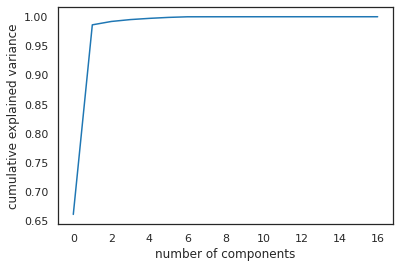

In [ ]:
pca = PCA().fit(train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 16-dimensional variance is contained within the first N components. For example, we saw that with the train data, we need around 1 component to describe close to 100% of the variance. However, we chose to use all features to train models.

In [ ]:
y_train = train['duration'].values
X_train = train.loc[:, ~train.columns.isin(['duration'])]
X_test = test

# Linear regression

#### Model Fitting

In [ ]:
lm = LinearRegression()

In [ ]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Model Prediction

In [ ]:
y_pred = lm.predict(X_test)
print(y_pred)

[ 553.5552065   453.80400119  394.13829308 ... 1425.84018985  688.96480515
  510.7168089 ]


#### Model Evaluation

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True) 
scores = cross_val_score(lm, X_train, y_train, cv=cv)
mse_scores = cross_val_score(lm, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print("MSE: %0.2f" % (-mse_scores.mean()))

0.61 accuracy with a standard deviation of 0.00
MSE: 115665.72


It seems like our model is better when we added features relavant to pickup datetime and the distance.

#### Submission

In [ ]:
submission = pd.DataFrame()
submission['duration'] = y_pred
submission.to_csv('lm_submission.csv', index = False)
submission.head()

,duration
0,553.555206
1,453.804001
2,394.138293
3,517.189294
4,765.964638


## Gradient Boosting Regressor

#### Model Fitting

In [ ]:
gbrt = GradientBoostingRegressor(loss = 'huber', learning_rate = 0.05,n_estimators = 1000, min_samples_split = 10, min_samples_leaf = 15,max_depth = 6,
                                 random_state = 42,max_features = 'sqrt')
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=6,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#### Model Prediction

In [ ]:
y_pred = gbrt.predict(X_test)
print(y_pred)

[ 649.56925577  159.62448828  397.28650277 ... 1828.93298111  617.74359815
  669.16080124]


#### Model Evaluation using K-Folds Cross-Validation

In [ ]:
cv = KFold(n_splits=2, random_state=1, shuffle=True) 
scores = cross_val_score(gbrt, X_train, y_train, cv=cv)
mse_scores = cross_val_score(gbrt, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print("MSE: %0.2f" % (-mse_scores.mean()))

0.81 accuracy with a standard deviation of 0.00
MSE: 57489.63


#### Submission 

In [32]:
submission = pd.DataFrame()
submission['duration'] = y_pred
submission.to_csv('gbrt_submission.gbrt', index = False)
submission.head()

,duration
0,649.569256
1,159.624488
2,397.286503
3,382.752352
4,942.064804


## Random Forest Regressor

#### Model Fitting

In [ ]:
rf = RandomForestRegressor(max_depth=20, n_estimators = 10,  random_state= 42)
rf.fit(X_train, y_train)

#### Model Prediction

In [ ]:
y_pred = rf.predict(X_test)
print(y_pred)

#### Model Evaluation

In [ ]:
cv = KFold(n_splits=2, random_state=1, shuffle=True) 
scores = cross_val_score(gbrt, X_train, y_train, cv=cv)
mse_scores = cross_val_score(gbrt, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print("MSE: %0.2f " % (-mse_scores.mean()))

#### Submission

In [ ]:
submission = pd.DataFrame()
submission['duration'] = y_pred
submission.to_csv('rf_submission.csv', index = False)
submission.head()